In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scipy

In [2]:
def create_dataset():

    df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')

    raw_data = []

    def load_dataset(file_name):
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', sr = None) 
        audio_16k = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000)
        audio_16k_mfcc = librosa.feature.mfcc(audio_16k, n_mfcc=20)
        return audio_16k_mfcc.tolist()


        
                
                    
    raw_data_list = []
    for _, row in df.iterrows():

        file_name = f"./UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"

        data = load_dataset(file_name)

        
        if len(data[0]) !=126:
            continue
            
        raw_data_list.append([data, row['class'], row['fold']])
        
    raw_data_list = pd.DataFrame(raw_data_list, columns = ['feature', 'class', 'fold'])

    y = np.array(raw_data_list['class'].tolist())
    
    return raw_data_list, y 

In [3]:
raw_data_list, y = create_dataset()

In [4]:
data = np.array(raw_data_list['feature'].tolist())

In [5]:
data.shape

(7326, 20, 126)

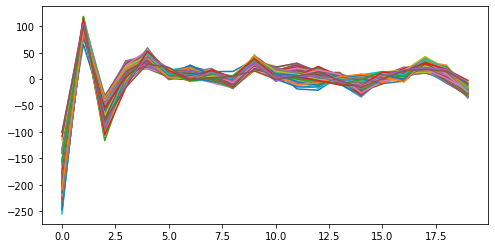

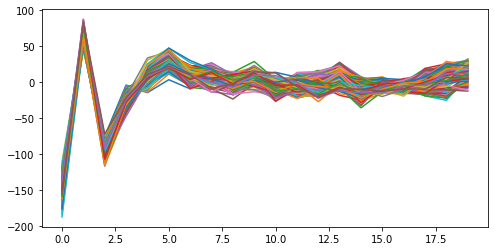

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(data[500])
plt.show()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(data[800])

In [7]:
raw_data_list['class'].unique()

array(['children_playing', 'dog_bark', 'air_conditioner', 'street_music',
       'siren', 'engine_idling', 'jackhammer', 'drilling', 'car_horn',
       'gun_shot'], dtype=object)

In [8]:
len(raw_data_list['class'].unique())

10

In [9]:
y_cat = tf.keras.utils.to_categorical(raw_data_list['class'].map(dict(zip(raw_data_list['class'].unique(), range(len(raw_data_list['class'].unique()))))).tolist() , num_classes=len(np.unique(y)))
y_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [10]:
def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img


normalized_data = normalize(data)

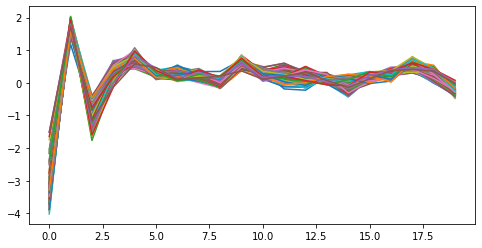

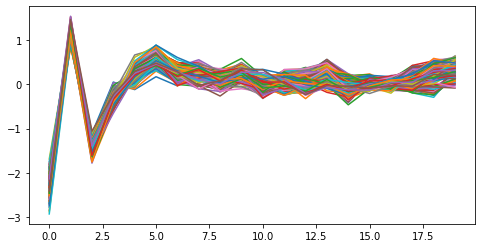

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(normalized_data[500])
plt.show()
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(normalized_data[800])

In [12]:
tr = np.where(raw_data_list['fold']<9)[0]
val = np.where(raw_data_list['fold'].isin([9,10]))[0]
#test = np.where(raw_data_list['fold']==10)[0]

print([tr.shape, val.shape])

[(5931,), (1395,)]


In [21]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 126, 20)]         0         
                                                                 
 lstm_20 (LSTM)              (None, 126, 128)          76288     
                                                                 
 lstm_21 (LSTM)              (None, 64)                49408     
                                                                 
 dense_14 (Dense)            (None, 10)                650       
                                                                 
Total params: 126,346
Trainable params: 126,346
Non-trainable params: 0
_________________________________________________________________


In [24]:
y_val.shape

(1395, 10)

In [27]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
    
from sklearn.metrics import *
bestacc = 0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Conv1D, AveragePooling1D, Attention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy



#for k in [-9, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]:

for df in [normalized_data, data]:
 for s in [True, False]:


            y_train = y_cat[tr]
            y_val = y_cat[val]

            x_train_copy = df[tr].copy()
            x_val_copy = df[val].copy()

            tf.random.set_seed(3)



            if s:

                x_train_copy = x_train_copy.reshape((x_train_copy.shape[0], x_train_copy.shape[2], x_train_copy.shape[1]))
                x_val_copy = x_val_copy.reshape((x_val_copy.shape[0], x_val_copy.shape[2], x_val_copy.shape[1]))


            inp = Input(shape=(x_train_copy.shape[1],x_train_copy.shape[2]))
            x = LSTM(32, return_sequences = True)(inp)
            x = LSTM(16)(x)
            out = Dense(y_cat.shape[1],activation='softmax')(x)

            model = Model(inputs=inp, outputs=out)

            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 0)

            optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
            model.compile(loss=CategoricalCrossentropy(from_logits=False), optimizer=optimizer, metrics=["accuracy"])
            history = model.fit(x_train_copy, y_train, batch_size=32, epochs=500, validation_data=(x_val_copy, y_val), verbose =1, callbacks = [es])


            pred_train = model.predict(x_train_copy)
            pred_val = model.predict(x_val_copy)

            curacc_train = accuracy_score(np.argsort(y_train,axis=1)[:,-1], np.argsort(pred_train,axis=1)[:,-1])
            curacc_val = accuracy_score(np.argsort(y_val,axis=1)[:,-1], np.argsort(pred_val,axis=1)[:,-1])

            model.save('my_model.h5')

            import os

            def get_size(path):
                size = os.path.getsize(path)
                if size < 1024:
                    return f"{size} bytes"
                elif size < 1024*1024:
                    return f"{round(size/1024, 2)} KB"
                elif size < 1024*1024*1024:
                    return f"{round(size/(1024*1024), 2)} MB"
                elif size < 1024*1024*1024*1024:
                    return f"{round(size/(1024*1024*1024), 2)} GB"



            print('______')
            print(['Train:', curacc_train, 'Val:', curacc_val] )
            #cm_val = confusion_matrix(np.argmax(y_val,axis=1), np.argmax(pred_val,axis=1))
            #print(cm_val)

            #cm_test = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1))
            #print(cm_test)
            #print([split_name, mitr, ump, l, d, bs, lr , outact, transpose, bn, 'Model Size:', get_size('my_model.h5')])

'''
['Train:', 0.6758333333333333, 'Val:', 0.5725, 'Test:', 0.59]
['mfcc_normalized', 0, True, 50, 32, 4, 0.001, 'softmax', False, False, 'Model Size:', '899.37 KB']
'''

Epoch 1/500
186/186 [==============================] - 5s 20ms/step - loss: 2.1876 - accuracy: 0.1406 - val_loss: 2.1155 - val_accuracy: 0.1864
Epoch 2/500
186/186 [==============================] - 3s 16ms/step - loss: 2.1165 - accuracy: 0.1747 - val_loss: 2.1160 - val_accuracy: 0.1821
Epoch 3/500
186/186 [==============================] - 3s 15ms/step - loss: 2.0503 - accuracy: 0.2177 - val_loss: 2.0942 - val_accuracy: 0.2022
Epoch 4/500
186/186 [==============================] - 3s 14ms/step - loss: 1.9587 - accuracy: 0.2841 - val_loss: 2.0561 - val_accuracy: 0.2165
Epoch 5/500
186/186 [==============================] - 3s 14ms/step - loss: 1.9412 - accuracy: 0.2890 - val_loss: 2.0575 - val_accuracy: 0.2401
Epoch 6/500
186/186 [==============================] - 2s 12ms/step - loss: 1.8036 - accuracy: 0.3527 - val_loss: 2.0497 - val_accuracy: 0.1957
Epoch 7/500
186/186 [==============================] - 2s 8ms/step - loss: 1.7045 - accuracy: 0.3880 - val_loss: 1.9692 - val_accuracy: 

186/186 [==============================] - 1s 8ms/step - loss: 0.8359 - accuracy: 0.7174 - val_loss: 1.5994 - val_accuracy: 0.4710
Epoch 19/500
186/186 [==============================] - 1s 7ms/step - loss: 0.8043 - accuracy: 0.7285 - val_loss: 1.5175 - val_accuracy: 0.5168
Epoch 20/500
186/186 [==============================] - 1s 6ms/step - loss: 0.7902 - accuracy: 0.7368 - val_loss: 1.4941 - val_accuracy: 0.5362
Epoch 21/500
186/186 [==============================] - 1s 6ms/step - loss: 0.7618 - accuracy: 0.7488 - val_loss: 1.7105 - val_accuracy: 0.4595
Epoch 22/500
186/186 [==============================] - 1s 8ms/step - loss: 0.7518 - accuracy: 0.7468 - val_loss: 1.6193 - val_accuracy: 0.4832
Epoch 23/500
186/186 [==============================] - 1s 7ms/step - loss: 0.7270 - accuracy: 0.7602 - val_loss: 1.5831 - val_accuracy: 0.5118
Epoch 24/500
186/186 [==============================] - 1s 6ms/step - loss: 0.6753 - accuracy: 0.7751 - val_loss: 1.5348 - val_accuracy: 0.5355
_____

"\n['Train:', 0.6758333333333333, 'Val:', 0.5725, 'Test:', 0.59]\n['mfcc_normalized', 0, True, 50, 32, 4, 0.001, 'softmax', False, False, 'Model Size:', '899.37 KB']\n"

In [18]:
y

array(['children_playing', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [ ]:
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten


inp = Input(shape=(x_train_copy.shape[1],x_train_copy.shape[2]))
#x = Conv1D(25, kernel_size=2)(inp)
x = LSTM(l,return_sequences= True )(inp)
x = Dropout(do)(x)
x = MaxPooling1D()(x)
x = LSTM(l)(x)
x = Dropout(do)(x)
x = Dense(d,activation='relu')(x)
x = Dropout(do)(x)
x = Dense(d,activation='relu')(x)
x = Dropout(do)(x)
out = Dense(y_cat.shape[1],activation=outact)(x)
model = Model(inputs=inp, outputs=out)

model.summary()

In [ ]:
model.save('my_model.h5')

import os

def get_size(path):
    size = os.path.getsize(path)
    if size < 1024:
        return f"{size} bytes"
    elif size < 1024*1024:
        return f"{round(size/1024, 2)} KB"
    elif size < 1024*1024*1024:
        return f"{round(size/(1024*1024), 2)} MB"
    elif size < 1024*1024*1024*1024:
        return f"{round(size/(1024*1024*1024), 2)} GB"
    
get_size('my_model.h5')

In [ ]:

pred_val = model.predict(x_val)
pred_test = model.predict(x_test)

curacc_val = accuracy_score(np.argsort(y_val,axis=1)[:,-1], np.argsort(pred_val,axis=1)[:,-1])
curacc_test = accuracy_score(np.argsort(y_test,axis=1)[:,-1], np.argsort(pred_test,axis=1)[:,-1])

cm_val = confusion_matrix(np.argmax(y_val,axis=1), np.argmax(pred_val,axis=1))
print(cm_val)

cm_test = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1))
print(cm_test)
print([curacc_val, curacc_test, mtc, bs, d ,l ,NUM_FEATURES])

In [ ]:
cm_val = confusion_matrix(np.argmax(y_val,axis=1), np.argmax(pred_val,axis=1))
print(cm_val)

cm_test = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred_test,axis=1))
print(cm_test)

In [ ]:
y_test.sum(axis=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig = plt.figure(figsize=(10,7))
    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = dict(zip(range(len(labelencoder.classes_)),labelencoder.classes_))

y_true = np.argsort(y,axis=1)[:,-1]
y_pred = np.argsort(ypreds,axis=1)[:,-1]

y_true
y_pred

cnf_matrix = confusion_matrix([class_names[x] for x in y_true],
                 [class_names[x] for x in y_pred],
                 labels=labelencoder.classes_)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')